주제: COVID-19발생지 및 대중교통 유동인구 분석과 대중교통 경로탐색

#<font color='#17a66a'>드라이브 연결</font>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#<font color='#17a66a'>데이터 확인</font>

In [ ]:
!ls drive/"My Drive"/Dacon/PostCorona/

'[케이티]행정동별 유동인구'
'[한국철도공사]여객 일별·역별 승  하차 실적'
'[한국철도공사]광역 일별·역별 시  간대별 승하차 실적'
'[한국교통연구원]차량 모빌리티 분  석맵(노드)'
'[한국교통연구원]차량 모빌리티 분  석맵(링크)'
'[한국교통안전공단]교통카드빅데이터  대중교통 이용정보'
'한국교통안전공단_버스정보시스템(BIS)_버스노선정보_20191231.csv'
'한국교통안전공단_버스정보시스템(BIS)_버스정류소정보_20191231.csv'
 data_df_2.csv
 datasets
'[DS4C]코로나19확진자데이터'
'[한국도로공사]DSRC 원시자료'
 googleMapAPIKey.txt
 HangJeongDong_ver20200101.geojson
 kakaoAPIKey.txt
 postcorona.pptx
 PTP000601.csv
 PTP000601.gsheet
 skorea_submunicipalities_geo_simple.json
 운영기관_역사_코드정보.xls


In [ ]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def FoundFileType(realPath):
  try: 
    reader = pd.read_csv(realPath)  #csv,dat 파일인 경우
    print('file type : csv')
  except:
    reader = pd.read_excel(realPath)  #엑셀 파일인 경우
    print('file type : excel')
  return reader

In [ ]:
def readFile(path):
  realPath = 'drive/My Drive/Dacon/PostCorona/'+ path #컴퓨터가 content없는 Type
  reader = FoundFileType(realPath)
  return reader

def readDat(path):
  realPath = 'drive/My Drive/Dacon/PostCorona/'+ path
  dat = np.fromfile(realPath,dtype = np.dtype('S32'))
  return dat

In [ ]:
path = 'drive/My Drive/Dacon/PostCorona/[한국교통안전공단]교통카드빅데이터  대중교통 이용정보/CARD_0001/DM_STTN_USEV_SMY.dat'  #예시
reader = pd.read_csv(path,skiprows=[0, 1e7], nrows=1e7, sep='|', header=None, )

In [ ]:
print(reader.shape)
reader.head() #데이터 앞부분 일부 보기

(10000000, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,20190101,11,11000,8,11100,B,4199420,누읍동휴먼시아,24250,0,3,3
1,20190101,11,11000,8,11100,B,4118401,누읍동휴먼시아,24416,9,0,9
2,20190101,11,11000,8,11100,B,4176447,대주피오레1단지,47862,29,36,65
3,20190101,11,11000,8,11100,B,4176455,대주피오레2단지,47860,85,79,164
4,20190101,11,11000,8,11100,B,4176446,대주피오레2단지상가앞,47858,51,0,51


라이브러리

In [ ]:
# 필요 라이브러리 실행
import pandas as pd
import json
import folium
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})
#import googlemaps

정류장이용량

In [ ]:
DM_STTN_USEV_SMY = pd.read_csv('drive/My Drive/Dacon/PostCorona/[한국교통안전공단]교통카드빅데이터  대중교통 이용정보/CARD_0001/DM_STTN_USEV_SMY.dat', skiprows=range(0,0), nrows=1e7, sep='|', header=None,engine='python')
columns = ['YYYYMMDD','시도 코드','시군구 코드','정산사 ID','정산 지역 코드', '교통수단 구분 코드', '정류장 ID', 'station_name', '정류장 ARS번호', '승차 건수', '하차 건수', 'total'] # 테이블 정의서 참조
DM_STTN_USEV_SMY.columns = columns

In [ ]:
display(DM_STTN_USEV_SMY)

,YYYYMMDD,시도 코드,시군구 코드,정산사 ID,정산 지역 코드,교통수단 구분 코드,정류장 ID,station_name,정류장 ARS번호,승차 건수,하차 건수,total
0,20190101,11,11000,8,11100,B,4123666,금강팬테리움,55545,14,99,113
1,20190101,11,11000,8,11100,B,4199420,누읍동휴먼시아,24250,0,3,3
2,20190101,11,11000,8,11100,B,4118401,누읍동휴먼시아,24416,9,0,9
3,20190101,11,11000,8,11100,B,4176447,대주피오레1단지,47862,29,36,65
4,20190101,11,11000,8,11100,B,4176455,대주피오레2단지,47860,85,79,164
...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,20190407,27,27140,14,2700000000,B,7011013400,불로우방아파트앞,~,181,103,284
9999996,20190407,27,27140,14,2700000000,B,7011000200,불로전통시장건너,~,744,87,831
9999997,20190407,27,27140,14,2700000000,B,7011000100,불로전통시장앞,~,287,117,404
9999998,20190407,27,27140,14,2700000000,B,7011000300,불로천주교회건너,~,144,86,230


In [ ]:
DM_STTN_USEV_SMY_F = DM_STTN_USEV_SMY.loc[:,['station_name','total']]

DM_STTN_USEV_SMY_F = DM_STTN_USEV_SMY_F.groupby('station_name').sum()

DM_STTN_USEV_SMY_F = DM_STTN_USEV_SMY_F.fillna(0.0)

display(DM_STTN_USEV_SMY_F)

,total
station_name,
(구)102보충대,97
(구)검문소,889
(구)구판장,17
(구)단대동주민센터,164288
(구)독정,287
...,...
힐튼호텔.현대아파트,34979
힐하우스,526
힘찬병원,158395


In [ ]:
path = '한국교통안전공단_버스정보시스템(BIS)_버스정류소정보_20191231.csv'
realPath = 'drive/My Drive/Dacon/PostCorona/'+ path #기본
contents = pd.read_csv(realPath, encoding = 'CP949', engine='python')

columns2 = ["1213", "station_name", "lng", "lat" , "123132", "123123"]
contents.columns = columns2

contents = contents.loc[:,['station_name','lat', 'lng']]
contents = contents.groupby('station_name').mean()

display(contents)

,lat,lng
station_name,,
(구)읍사무소,36.870388,128.524575
(구)축협,36.006812,127.662710
102기갑여단,38.238839,128.511681
119구조대,38.195888,128.577787
1958부대,38.185003,127.329702
...,...,...
흥전1리.도계유리마을,37.213414,129.038980
흥전리,37.220044,129.028887
흥촌,35.671988,126.922597


In [ ]:
DM_STTN_USEV_SMY_F = pd.merge(DM_STTN_USEV_SMY_F, contents, on='station_name')  #행정동코드를 행정동명으로 매핑하기

In [ ]:
map_info = np.array(DM_STTN_USEV_SMY_F)

In [ ]:
map = folium.Map(location = [37.239, 127.512], zoom_start=8)

#마커 좌표를 지도에 찍기
for i in map_info:
    folium.CircleMarker([i[1], i[2]],radius=2,popup = str(i[0]),fillcolor='#5e1613').add_to(map)

In [ ]:
map

Output hidden; open in https://colab.research.google.com to view.

#<font color='#17a66a'>코로나 맵 좌표 전처리 및 시각화 </font>
  위경도 좌표가 존재하는 데이터만을 사용

In [ ]:
!pip install googlemaps
!pip install folium
import pandas as pd
import numpy as np
import folium

  Created wheel for googlemaps: filename=googlemaps-4.4.2-cp36-none-any.whl size=37858 sha256=c6c148e26310080213bca869ee24ec91c9a5731fb0c925aa084528d0aa11d6d1
  Stored in directory: /root/.cache/pip/wheels/f4/21/41/0c84572e21d52bb322f6c299f38ac7cd8ad6d4d6ce23dc3631
Successfully built googlemaps


In [ ]:
def get_col(col, reader):
  ndarray = reader.to_numpy()
  try: # 해당 col을 탐색
    column = ndarray[:,col].astype(np.float64) #  데이터 타입을 float으로 변경
  except: # 숫자가 아닌경우 일단 문자열로 받기
    column = ndarray[:,col]
  return column

In [ ]:
path = "latlng.xlsx" #미리저장해둔 주요도시 위도경도

realPath = 'drive/My Drive/Dacon/PostCorona/[DS4C]코로나19확진자데이터/'+ path #컴퓨터가 content없는 Type
reader = pd.read_excel(realPath)

In [ ]:
cities = np.array(get_col(0,reader)) #도시 배열
lats = np.array(get_col(1,reader)) #위도 배열
lngs = np.array(get_col(2,reader)) #경도 배열
cll = np.array([cities,lats,lngs]).T #합체

#print(cll) #구조를 보기위해 실행

In [ ]:
def get_latlng_by_city(city,cll=cll): #도시이름 넣으면 위도 경도 알려주는 함수
  index = np.array(np.where(cll==city))
  i = index[1][0]
  latlng = np.float64([cll[index[0][0],i+1],cll[index[0][0],i+2]])
  return latlng

In [ ]:
def get_latlng(row,noise): #하나의 Case.csv의 row에서 위도경도 가져오기
  if (row[6] == '-'): #위도 경도가 null이면
    if noise:
      result = get_latlng_by_city(city= row[1]) #도시에 해당하는 위도경도로 변경
      noise = 0.02 * np.random.normal(size = 2) #noise를 주어 정확히 같은 위치로 지정되는것을 회피
      result = result + noise
    else:
      result = "no_data" #noise없는 버전
  else:
    result = np.float64([row[6] ,row[7]]) #위도경도 추출, 빈곳은 '-'처리되어있음
  return result

In [ ]:
#맵 예시
map_view = folium.Map(
    location=[36,127.5],
    zoom_start=7
)

In [ ]:
#Case.csv가져와서 numpy 행열로 만들기
#noise는 좌표가 없는데이터를 도시이름기반으로 생성하면 true, 생성된좌표는 항상 다른값을 가지도록 랜덤한 수를 더해줌
def check_corona(map, noise = False):
  path = "Case.csv" #Case.csv
  try: 
    realPath = 'content/drive/My Drive/Dacon/PostCorona/[DS4C]코로나19확진자데이터/'+ path #기본
    reader = pd.read_csv(realPath)
  except FileNotFoundError:
    realPath = 'drive/My Drive/Dacon/PostCorona/[DS4C]코로나19확진자데이터/'+ path #컴퓨터가 content없는 Type
    reader = pd.read_csv(realPath)

  ndarray = reader.to_numpy()
  for i in range (ndarray.shape[0]):
    latlng = get_latlng(ndarray[i], noise) #latlng 전처리 함수
    if latlng != "no_data":
      folium.CircleMarker(
      location = latlng,
      radius=3,
      color='#ff3333',
      fill_color='#ff3333',
      popup='infected'
      ).add_to(map) #지도에 marker 추가하기
    else: pass

  return map

지도에 코로나 발생지점의 좌표를 표시할 수 있음.

In [ ]:
check_corona(map_view)
#함수 사용 예시
#반환값을 받아 사용도 가능하다.
#map_view = check_corona(map_view)

**COVID-19 감염상황을 CASE(집단/개인)별로 분류하여 시각화하였습니다.**

> 분석 결과 집단 감염의 사례가 더 많았음이 확인되었고, 이를 통해 교통 데이터 분석과 코로나 데이터의 융합 분석을 통한, 안전한 이동경로 확보가 중요하다는 결론을 내렸습니다.







In [ ]:
import os
import pandas as pd
import csv

import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
%matplotlib inline

import folium
import json

from IPython.display import display

from google.colab import files
from google.colab import drive

import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
folder ='drive/My Drive/Dacon'

In [ ]:
SEOUL_COORDINATES = (37.566345, 126.977893)
state_geo_path = folder + '/TL_SCCO_CTPRVN.json'
state_geo=json.load(open(state_geo_path, encoding = 'UTF-8'))
Data = pd.read_csv(folder+'/coronavirusdataset_20200601/Case.csv')
DataDF = pd.pivot_table(Data,index='province',aggfunc=np.sum)
Data_map = folium.Map(location=SEOUL_COORDINATES, zoom_start=7)

bins_term = [0,100,500,1000,2000,10000]
folium.Choropleth (geo_data = state_geo,
               data = DataDF['confirmed'],
               columns = [DataDF.index, DataDF['confirmed']],
               key_on='feature.properties.CTP_ENG_NM',
               fill_color='PuRd',
               fill_opacity=0.7,
               line_opacity=0.2,
               legend_name='confirmed',
               bins = bins_term,
               reset=True
               ).add_to(Data_map)

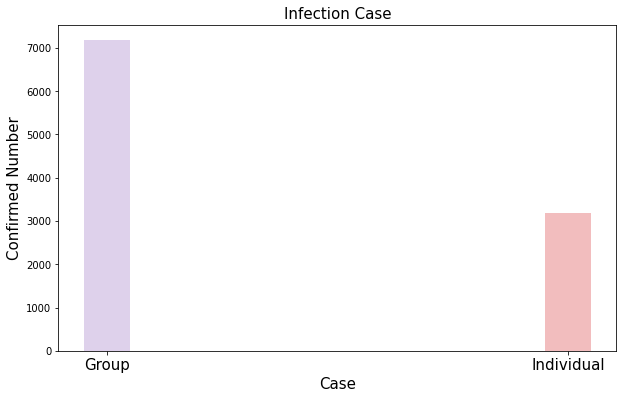

In [ ]:
group_local_data = []
group_case = 0
individual_case = 0
labels_group = ['Group','Individual']
with open(folder+'/coronavirusdataset_20200601/Case.csv','r', encoding = 'UTF-8') as f:
    reader = csv.DictReader(f)
    for i in reader:
        temp_local_data = []
        if i['group']=='TRUE':
            if i['confirmed'] != '':
              group_case += int(i['confirmed'])
            else:
              pass
            try:
                temp_local_data = [float(i['latitude']),float(i['longitude'])]
                if temp_local_data not in group_local_data:
                    group_local_data.append(temp_local_data)
                    info_popup = folium.Popup(
                        '*Case :'+i['infection_case']+'<br>'+'*Number :'+i['confirmed'],
                        max_width = 300,
                    )
                    folium.Marker(
                        temp_local_data,
                        popup=info_popup,
                        icon=folium.Icon(color='red',icon='info-sign')
                    ).add_to(Data_map)
            except:
                pass
        else:
            if i['confirmed'] != '':
              individual_case += int(i['confirmed'])
    labels_group = ['Group','Individual']
    ratio_group = [group_case,individual_case]
    index = np.arange(len(labels_group))
    plt.bar(index,ratio_group,width=0.1, color=['tab:purple','tab:red'], alpha=0.3)
    plt.title('Infection Case', fontsize=15)
    plt.xlabel('Case', fontsize=15)
    plt.ylabel('Confirmed Number', fontsize=15)
    plt.xticks(index, labels_group, fontsize=15)
    plt.show()
display(Data_map)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,592 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

**공공 데이터 포털 URL을 통해전국 지하철 정보를 순차적으로 로드하여 Data Frame으로 변환하고 Data Table을 확인하였습니다.**


> 유동 인구 데이터와 결합하여 이후에 경로 추천을 위한 알고리즘을 위한 가중치 점수를 환산하는 과정에서 사용할 예정입니다.





In [ ]:
#필요한 지하철 정보 불러오기 1.
import xml.etree.ElementTree as ET
import sys
import pandas as pd
if sys.version_info[0]==3:
  from urllib.request import urlopen
else:
  from urllib import urlopen
url_busan = "http://openapi.tago.go.kr/openapi/service/MetroRtInfoService/getMetroLineInfoList?serviceKey=PkCGhu3ZTniEfvNRt7sE20DxVYDD2FhCYQnBr03YFfV7nqwez0teWzdC3h4ciJMGdj2e%2BhjizrYzg1hdcltrvg%3D%3D&pageNo=1&numOfRows=10&cityCd=BS&lineNo=4&"
response_busan = urlopen(url_busan).read()
busan_tree = ET.fromstring(response_busan)
busan_node = busan_tree.findall('body/items/item')
print('The number of stations:', len(busan_node))
rows=[]
for node in busan_node:
  n_line = node.find("lineNo").text
  n_station = node.find("stationNm").text
  order = node.find("routOrd").text
  rows.append({"Line":n_line,
               "Station":n_station,
               "Order":order})
BUSAN_DF = pd.DataFrame(rows,columns = ["Line","Station","Order"])
BUSAN_DF

The number of stations: 10


,Line,Station,Order
0,4,안평,1
1,4,고촌,2
2,4,동부산대학,3
3,4,영산대,4
4,4,석대,5
5,4,반여농산물시장,6
6,4,금사,7
7,4,서동,8
8,4,명장,9
9,4,충렬사,10


In [ ]:
#필요한 지하철 정보 불러오기 2.
Data_Subway = pd.read_csv(folder+'/한국철도공사_도시철도노선정보_20170530.csv',encoding = 'CP949')
Data_Subway

,노선번호,노선명,기점명,종점명,정거장구성,노선연장,개통일자,운영기관명,운영기관전화번호,데이터기준일자
0,k1211,동해선,부전,일광,"K410-부전역, K411-거제해맞이역, K412-거제역, K413-교대역, K41...",28000,2016-12-30,한국철도공사,1544-7788,2017-05-30
1,k1218,경강선,판교,여주,"K410-판교역, K412-삼동역, K413-경기광주역, K414-초월역, K415...",54800,2016-09-24,한국철도공사,1544-7788,2017-05-30
2,k1215,수인선,오이도,인천,"K251-달월역, K252-월곶역, K253-소래포구역, K254-인천논현역, K2...",20400,2012-06-30,한국철도공사,1544-7788,2017-05-30
3,k1210,경춘선,상봉,춘천,"P122-신내역, P123-갈매역, P124-별내역, P125-퇴계원역, P126-...",81300,2010-10-01,한국철도공사,1544-7788,2017-05-30
4,k1305,일산선,지축,대화,"0319-지축역, 0318-삼송역, 0317-원흥역, 0316-원당역, 0315-화...",19200,1996-10-01,한국철도공사,1544-7788,2017-05-30
5,k1304,분당선,왕십리,수원,"K245-수원(분당)역, K211-서울숲역, K212-압구정로데오역, K213-강남...",52900,1994-10-01,한국철도공사,1544-7788,2017-05-30
6,k1303,안산·과천선,남태령,오이도,"435선바위역, 436경마공원역, 437대공원역, 438과천역, 439정부과천청사역...",40400,1988-10-01,한국철도공사,1544-7788,2017-05-30
7,k1212,경의중앙선,용문,문산,"P313-서울역(경의선), P314-신촌역, K315-가좌역, K311-효창공원앞역...",118700,1899-09-18,한국철도공사,1544-7788,2017-05-30
8,k1205,경원선,청량리,소요산,"0123-회기역, 0122-외대앞역, 0121-신이문역, 0120-석계역, 0119...",42900,1974-10-01,한국철도공사,1544-7788,2017-05-30
9,k1301,경인선,구로,인천,"0142-구일역, 0143-개봉역, 0144-오류동역, 0145-온수역, 0146-...",27000,1905-01-01,한국철도공사,1544-7788,2017-05-30


**URL을 통해 로드한 정보를 Data Frame으로 변환한 이후 필요한 정보를 Passing하여 Data Frame을 구축한 뒤 확인하였습니다.**

In [ ]:
#url 크롤링하는것 시간 많이걸림.
try:
    from urllib.parse import quote
except ImportError:
     from urlparse import quote
#필요한 지하철 정보 불러오기 3.
print(Data_Subway['정거장구성'])
station = ''
array = []
for i, row in Data_Subway.iterrows() :
    for k in Data_Subway.at[i,'정거장구성']:
      if k != '-' and k !=',' and k!='역' and k != 'K' and k !='P' and ord(k)>81:
            station = station + k
      if k == '역':
            array.append(station)
            station = ''
url_station = "http://openapi.tago.go.kr/openapi/service/SubwayInfoService/getKwrdFndSubwaySttnList?serviceKey=PkCGhu3ZTniEfvNRt7sE20DxVYDD2FhCYQnBr03YFfV7nqwez0teWzdC3h4ciJMGdj2e%2BhjizrYzg1hdcltrvg%3D%3D&subwayStationName="
print(array)
for i in array:
    response_station = urlopen(url_station + quote(i) + '&').read()
    station_tree = ET.fromstring(response_station)
    station_node = station_tree.findall('body/items/item')
    station_rows=[]
    for node in station_node:
      n_subwayRouteName = node.find("subwayRouteName").text
      n_subwayStationId = node.find("subwayStationId").text
      n_subwayStationName = node.find("subwayStationName").text
      rows.append({"Line":n_subwayRouteName,
                  "Station":n_subwayStationId,
                  "Name":n_subwayStationName})
    station_DF = pd.DataFrame(rows,columns = ["Line","Station","Name"])
print(station_DF)

0     K410-부전역, K411-거제해맞이역, K412-거제역, K413-교대역, K41...
1     K410-판교역, K412-삼동역, K413-경기광주역, K414-초월역, K415...
2     K251-달월역, K252-월곶역, K253-소래포구역, K254-인천논현역, K2...
3     P122-신내역, P123-갈매역, P124-별내역, P125-퇴계원역, P126-...
4     0319-지축역, 0318-삼송역, 0317-원흥역, 0316-원당역, 0315-화...
5     K245-수원(분당)역, K211-서울숲역, K212-압구정로데오역, K213-강남...
6     435선바위역, 436경마공원역, 437대공원역, 438과천역, 439정부과천청사역...
7     P313-서울역(경의선), P314-신촌역, K315-가좌역, K311-효창공원앞역...
8     0123-회기역, 0122-외대앞역, 0121-신이문역, 0120-석계역, 0119...
9     0142-구일역, 0143-개봉역, 0144-오류동역, 0145-온수역, 0146-...
10    0134-남영역, 0135-/ K110-용산역 013-노량진역, 0137-대방역, ...
Name: 정거장구성, dtype: object
['부전', '거제해맞이', '거제', '교대', '동래', '안락', '재송', '센텀', '벡스코', '신해운대', '송정', '오시리아', '기장', '일광', '판교', '삼동', '경기광주', '초월', '곤지암', '신둔도예촌', '이천', '부발', '세종대왕릉', '여주', '달월', '월곶', '소래포구', '인천논현', '호구포', '남동인더스파크', '원인재', '연수', '송도', '인하대', '숭의', '신포', '신내', '갈매', '별내', '퇴계원', '사릉', '금곡', '평내호평', '천마산', '마석', '대성리', '청평', '상천', '가평', '굴봉산', '백양리', '강촌', '김유정', '

**공공 데이터 포털의 자료를 융합하여 전국 지하철 출구 번호와 인근 버스 정류장 정보를 Join한 Data Frame을 제작하였습니다. 다음은 시험용으로 서울 1호선 역들의 출구와 인접한 버스정류장들에 관한 정보를 담은 Data Frame입니다.**

In [ ]:
for i, row in station_DF.iterrows() :
    if station_DF.at[i,'Line'] == '서울 1호선':
      address = station_DF.at[i,'Station']
      url_bus = "http://openapi.tago.go.kr/openapi/service/SubwayInfoService/getSubwaySttnExitAcctoBusRouteList?serviceKey=PkCGhu3ZTniEfvNRt7sE20DxVYDD2FhCYQnBr03YFfV7nqwez0teWzdC3h4ciJMGdj2e%2BhjizrYzg1hdcltrvg%3D%3D&subwayStationId="
      response_bus = urlopen(url_bus + address + '&').read()
      bus_tree = ET.fromstring(response_bus)
      bus_node = bus_tree.findall('body/items/item')
      bus_rows=[]
      for node in bus_node:
        n_busRouteNo = node.find("busRouteNo").text
        n_exitNo = node.find("exitNo").text
        rows.append({"BusNumber":n_busRouteNo,
                    "ExitNumber":n_exitNo})
      bus_DF = pd.DataFrame(rows,columns = ["BusNumber","ExitNumber"])
print(bus_DF)

          BusNumber ExitNumber
0               NaN        NaN
1               NaN        NaN
2               NaN        NaN
3               NaN        NaN
4               NaN        NaN
...             ...        ...
1452     11(두정우남A행)          1
1453     11(두정한성A행)          1
1454   110(남서울대학교행)          1
1455      110(천안역행)          1
1456  194(천안아산역 방면)          1

[1457 rows x 2 columns]


#<font color='#17a66a'>구글맵으로 좌표 및 경로 가져와 folium지도에 그리기</font>
----------------
<font color='#17a66a'>사용법</font>
----------------
아래코드를 하나씩 실행한 뒤 맨밑의 코드가지고 출발지, 도착지로 검색,

경유지를 넣어 검색 할 수 있도록 파라미터가 준비되어있지만 대중교통 모드에서는 라이브러리에서 불가능하다고 되어 있어 경유지만큼 싱행하도록 했습니다.

In [ ]:
!pip install googlemaps
!pip install folium

In [ ]:
from urllib.parse import quote
from urllib.request import Request, urlopen
import ssl
import json
import folium
import googlemaps
import urllib.request
import requests 

In [ ]:
# https://github.com/geodav-tech/decode-google-maps-polyline 
#참고자료 - 구글api에서 사용하는 polyline을 decode하기 위함
# This function is free of any dependencies.
def decode_polyline(polyline_str): #depth = 2
    '''Pass a Google Maps encoded polyline string; returns list of lat/lon pairs'''
    index, lat, lng = 0, 0, 0
    coordinates = []
    changes = {'latitude': 0, 'longitude': 0}

    # Coordinates have variable length when encoded, so just keep
    # track of whether we've hit the end of the string. In each
    # while loop iteration, a single coordinate is decoded.
    while index < len(polyline_str):
        # Gather lat/lon changes, store them in a dictionary to apply them later
        for unit in ['latitude', 'longitude']: 
            shift, result = 0, 0

            while True:
                byte = ord(polyline_str[index]) - 63
                index += 1
                result |= (byte & 0x1f) << shift
                shift += 5
                if not byte >= 0x20:
                    break

            if (result & 1):
                changes[unit] = ~(result >> 1)
            else:
                changes[unit] = (result >> 1)

        lat += changes['latitude']
        lng += changes['longitude']

        coordinates.append((lat / 100000.0, lng / 100000.0))

    return coordinates

# This function requires Esri's arcpy module.
def convert_to_shapefile(steps, output_shapefile): #depth = 2
    '''Pass the steps object returned by the Maps API (should be response['routes'][0]['legs'][0]['steps'])
    and an output shapefile path; outputs a detailed shapefile of that route'''
    
    import arcpy
    import os

    # Decode each step of the route; add those coordinate pairs to a list
    total_route = []
    for step in steps:
        total_route += decode_polyline(step['polyline']['points'])

    # Create empty WGS84 shapefile.
    sr = arcpy.SpatialReference(4326)
    arcpy.CreateFeatureclass_management(os.path.dirname(output_shapefile), os.path.basename(output_shapefile), 
        "POLYLINE", spatial_reference=sr)

    # Add points to array, write array to shapefile as a polyline
    arr = arcpy.Array()
    for coord_pair in total_route:
        arr.add(arcpy.Point(coord_pair[1], coord_pair[0]))
    with arcpy.da.InsertCursor(output_shapefile, ['SHAPE@']) as rows:
        rows.insertRow([arcpy.Polyline(arr)])
    del rows

    return output_shapefile

In [ ]:
def get_key(path = "googleMapAPIKey.txt"): #key 가져오기, depth = 2
  try: 
    realPath = 'content/drive/My Drive/Dacon/PostCorona/'+ path #GPU사용모드
    keyFile = open(realPath)
  except FileNotFoundError:
    realPath = 'drive/My Drive/Dacon/PostCorona/'+ path #기본 모드
    keyFile = open(realPath)
  api_key = keyFile.readline()
  keyFile.close()
  return api_key

address:문자열 주소, location:좌표리스트를 string 좌표로 변환하거나 list좌표로 변환하는 함수들

---------------------------
address to location함수는 geocode라는 구글맵 api를 사용했습니다.

In [ ]:
#location을 문자열로 변환, depth = 5
def location_to_string(location):
  string = str(location[0]) +','+ str(location[1])
  return string

#주소로 좌표가져오기, depth = 4
def address_to_location(address):
  json_result = client.geocode(address, language='ko') #string주소로 좌표받아오기 예시
  latlng = json_result[0]['geometry']['location'] #lat, lng 위도 경도
  location = [latlng['lat'],latlng['lng']]
  return location_to_string(location)

def address_to_location_list(address):
  json_result = client.geocode(address, language='ko') #string주소로 좌표받아오기 예시
  latlng = json_result[0]['geometry']['location'] #lat, lng 위도 경도
  location = [latlng['lat'],latlng['lng']]
  return location


구글 맵 API사용함. - Directions

In [ ]:
#출발지와 도착지로 경로가져오기, depth = 3
api_key = get_key()
def get_path(origin_string,destination_string,mode = "transit", departure_time = "now",key = api_key): #api key, 출발지, 도착지
  origin = address_to_location(origin_string)
  destination = address_to_location(destination_string)
#https://developers.google.com/maps/documentation/urls/get-started -> 라이브러리 참고
  url = "https://maps.googleapis.com/maps/api/directions/json?origin="+ origin \
          + "&destination=" + destination \
          + "&mode=" + mode \
          + "&departure_time=" + departure_time\
          + "&language=ko" \
          + "&key=" + key #\
          #+ "&RoutingAlternatives=true"

  request         = urllib.request.Request(url)
  context         = ssl._create_unverified_context()
  response        = urllib.request.urlopen(request, context=context)
  responseText    = response.read().decode('utf-8')
  responseJson    = json.loads(responseText)
  return responseJson

polyline으로 지도에 그리기 위해 Directions의 결과값(Json)을 열어 필요한 정보를 반환하는 함수

In [ ]:
#depth = 2(함수 깊이)
def response_to_points(origin,destination):
  responseJson = get_path(origin,destination)  #responseJson(api를 통해 받은 결과)을 가지고 경로 요약
  #print(responseJson)
  try:
    path = responseJson["routes"][0]["legs"][0]
    duration_sec = path["duration"]["value"]
    start_geo = path["start_location"]
    end_geo = path["end_location"]
    overview_points = responseJson["routes"][0]["overview_polyline"]
    result = [start_geo,end_geo,overview_points,path]
  except:
    result = "fail"
  return result

출발지와 목적지로 지도에 polyline으로 경로를 그려주는 함수,

Directions Api를 사용해 json파일을 여는 함수를 호출합니다.

In [ ]:
#depth = 1(함수 깊이) main = 0
def path_google_directions(origin,destination, point_detail = False,zoom = 12, map_view = None):   #구글맵 api를 활용해 경로를 보여주는 함수
  # 구글맵API Authorization및 초기화
  global client
  try:
    client = client# client가 정의되지 않았을 경우
  except: # client설정
    key = get_key()
    client = googlemaps.Client(key)
  start_location = [37.5536067,126.9696195] #default = 서울역

  result = response_to_points(origin,destination)
  if result == "fail":
    pass
  else:
    start_geo = result[0]
    end_geo = result[1]
    overview_points = result[2]
    path = result[3]

    if map_view == None:
      start_location = [(start_geo['lat'] + end_geo['lat'])/2,(start_geo['lng'] + end_geo['lng'])/2]
      map_view = folium.Map(
          location=start_location,
          zoom_start=zoom
      )
    #경로의 타입을 구별 : 도보, 버스 등

    stepList = path["steps"]
    for step in stepList:
      polyline = step["polyline"]
      travel_mode = step["travel_mode"]
      points = decode_polyline(polyline["points"])
      if point_detail:
        print(travel_mode)
        print(points)
        print("")
      folium.PolyLine(points).add_to(map_view)
  return map_view

  #points = decode_polyline(overview_points["points"]) # 경로 타입 구별안하고 경로만
  #folium.PolyLine(points).add_to(map_view)

google Directions에서 Transit모드는 waypoints가 지원되지 않아 여러번 실행하여 해결하도록 하는 함수,

waypoint위치도 표시해줍니다.

In [ ]:
#구글api로 가져온 맵 (출발지,도착지,point_detail = False, zoom = 16)
#google Directions
def request_direction(origin,destination,waypoint=None,waypoint2=None):
  #출발지, 목적지, waypoint
  #경로탐색 google api : Directions을 사용.
  if waypoint2 !=None:
    map = path_google_directions(origin, waypoint)
    map = path_google_directions(waypoint, waypoint2,map_view = map)
    map = path_google_directions(waypoint2,destination,map_view = map)

    location = address_to_location_list(waypoint)
    folium.CircleMarker(
        location = location,
        radius=3,
        color='#ffffff',
        fill_color='#ffffff',
        popup='waypoint'
        ).add_to(map) #지도에 marker 추가하기

    location = address_to_location_list(waypoint2)
    folium.CircleMarker(
        location = location,
        radius=3,
        color='#ffffff',
        fill_color='#ffffff',
        popup='waypoint2'
        ).add_to(map) #지도에 marker 추가하기
  elif waypoint != None:
    map = path_google_directions(origin, waypoint)
    map = path_google_directions(waypoint,destination,map_view = map)
    
    location = address_to_location_list(waypoint)
    folium.CircleMarker(
        location = location,
        radius=3,
        color='#ffffff',
        fill_color='#ffffff',
        popup='waypoint'
        ).add_to(map) #지도에 marker 추가하기
  else:
    map = path_google_directions(origin,destination)
  check_corona(map)

  print("origin :",origin)
  print("destination :",destination)

  return map

사용 예시

In [ ]:
# waypoint 사용 예시 origin, destination, waypoint, waypoint2
# origin, destination은 필수 입력, waypoin1,2는 선택입력
# 전부str형, lat,lng 또는 지역명사용.
# 맵을 반환받아 사용할 수 있음.

m = request_direction("홍대입구역", "화정역") 
display(m)

m = request_direction("홍대입구역", "화정역", "서울역") 
display(m)

origin : 홍대입구역
destination : 화정역


origin : 홍대입구역
destination : 화정역


#<font color='#17a66a'>kt 행정동별 유동인구 데이터 로드</font>
같은성별의 5세단위의 연령을 하나의 그륩으로 놓고
기준 년월일에 행정동 마다 유동인구를 그륩별로 유동인구를 기록. 유동인구는 시간단위 0~ 23까지 존재함.

-----------
<font color='#17a66a'>데이터 특성</font>
-----------
데이터 양이 많다

데이터에 빠진것이 없음

날짜가 명확하게 설정되어있고 1시간단위의 세세한 정보 

연령별로 유동인구가 표시됨-> 특수연령층의 유동인구 분석가능

행정동별의 지역적세부정보포함 -> 지역별로 분석 할 수 있다.

------
<font color='#17a66a'>시각화</font>
------
코로나 19데이터의 확진자의 판정데이터와 지역 날짜 + 유동인구의 크기로 현재 날짜의 위험도를 지도에 표시 할 수 있음.

In [ ]:
import pandas as pd 
import numpy as np

In [ ]:
# 데이터 로드 시작
path = '[케이티]행정동별 유동인구/fpopl_2020.csv'
def FoundFileType(realPath):
  try: 
    reader = pd.read_csv(realPath)  #csv,dat 파일인 경우
    print('file type : csv')
  except:
    reader = pd.read_excel(realPath)  #엑셀 파일인 경우
    print('file type : excel')
  return reader

realPath = 'drive/My Drive/Dacon/PostCorona/'+ path 
reader = FoundFileType(realPath)

path = '[케이티]행정동별 유동인구/adstrd_master.csv'

realPath = 'drive/My Drive/Dacon/PostCorona/'+ path 
adstrd_master = FoundFileType(realPath)

display(reader.shape)  #행렬 
display(reader.head()) #데이터 앞부분 일부 보기

display(adstrd_master.shape)
display(adstrd_master.head())

file type : csv
file type : csv


(25737734, 6)

,base_ymd,tmzon_se_code,sexdstn_se_code,agrde_se_code,adstrd_code,popltn_cascnt
0,20200111,0,F,age_00,11320681,8
1,20200111,0,F,age_00,11350621,17
2,20200111,0,F,age_00,11500591,7
3,20200111,0,F,age_00,11590651,4
4,20200111,0,F,age_00,11650531,25


(3493, 4)

,adstrd_code,adstrd_nm,brtc_nm,signgu_nm
0,11110515,청운효자동,서울특별시,종로구
1,11110530,사직동,서울특별시,종로구
2,11110540,삼청동,서울특별시,종로구
3,11110550,부암동,서울특별시,종로구
4,11110560,평창동,서울특별시,종로구


날짜, 시간, 성별, 연령대의 분석이 가능하다.
--------------------------
고령층의 행정동별 유동인구 데이터를 지도에 시각화하고 코로나발생데이터와의 관계를 분석할 수 있음.

In [ ]:
data = reader
data = data[data.base_ymd < 20200301]  #특정날짜
#data = data[data.tmzon_se_code == 18] #특정 시간
#reader = reader[reader.sexdstn_se_code == "M"] #성별
data_all_age = data #모든 연령대
d1 = data[data.agrde_se_code == "age_60"] #특정 연령대
d2 = data[data.agrde_se_code == "age_65"]
d3 = data[data.agrde_se_code == "age_70"]
data = d1.append(d2).append(d3)

data_all_age = data.loc[:,['adstrd_code','popltn_cascnt']]
data = data.loc[:,['adstrd_code','popltn_cascnt']] #조건에 맞는 일부 데이터

data_all_age = data_all_age.groupby('adstrd_code').sum()
data_all_age = pd.merge(data_all_age, adstrd_master, on='adstrd_code')
data = data.groupby('adstrd_code').sum() #성별등의 사용되지않은 조건으로 인한 분산데이터를 적립
data = pd.merge(data, adstrd_master, on='adstrd_code')  #행정동코드를 행정동명으로 매핑하기

display(data_all_age)
display(data_all_age.shape)

#data를 다듬은geojson의 key형태와 같게 만들어준다.
for i in range(len(data_all_age)):
  data_all_age.loc[i,"adstrd_code"] = str(data_all_age.loc[i,"adstrd_code"])+"00"
for i in range(len(data)):
  data.loc[i,"adstrd_code"] = str(data.loc[i,"adstrd_code"])+"00"

,adstrd_code,popltn_cascnt,adstrd_nm,brtc_nm,signgu_nm
0,11110515,551268,청운효자동,서울특별시,종로구
1,11110530,1585416,사직동,서울특별시,종로구
2,11110540,266251,삼청동,서울특별시,종로구
3,11110550,921099,부암동,서울특별시,종로구
4,11110560,1045354,평창동,서울특별시,종로구
...,...,...,...,...,...
420,11740650,1412915,성내2동,서울특별시,강동구
421,11740660,2235505,성내3동,서울특별시,강동구
422,11740685,2024769,길동,서울특별시,강동구
423,11740690,602046,둔촌1동,서울특별시,강동구


(425, 5)

구역을 나누어 GeoJson함수를 이용해 그라데이션 형태로 색을 나타내어 서울특별시 행정동별 유동인구수를 시각화 해봤습니다.

geoJson은 https://github.com/vuski/admdongkor 에서 받아 서울특별시만을 남기도록 가공하여 사용했습니다.

In [ ]:
import json
import folium
SEOUL_COORDINATES = (37.566345, 126.977893)
folder = 'drive/My Drive/Dacon/PostCorona/'
state_geo_path = folder + 'HangJeongDong_ver20200101.geojson'
state_geo=json.load(open(state_geo_path, encoding = 'UTF-8'))

data_dict = data.set_index('adstrd_code')['popltn_cascnt']

Data_map = folium.Map(location=SEOUL_COORDINATES, zoom_start=11,tiles='cartodbpositron')
Data_map_all_age = folium.Map(location=SEOUL_COORDINATES, zoom_start=11,tiles='cartodbpositron')
#folium.GeoJson(state_geo).add_to(Data_map)

from branca.colormap import linear
colormap = linear.YlGn_09.scale(
    data.popltn_cascnt.min(),
    data.popltn_cascnt.max())
colormap_all_age = linear.YlGn_09.scale(
    data_all_age.popltn_cascnt.min(),
    data_all_age.popltn_cascnt.max())
'''
folium.GeoJson(
    state_geo,
    name='data',
    style_function=lambda feature: {
        'fillColor': colormap(data_dict[feature['properties']['adm_cd2']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5,
    }
).add_to(Data_map)

print("2020년 1월 1일부터 2020년 3월 1일까지 고령층 유동인구")
Data_map = check_corona(Data_map,noise = True) #코로나 발생지점을 점으로 찍는 함수
display(Data_map)
'''
# 고령유동인구와 전연령 유동인구의 맵결과값이 매우 유사하여 하나를 제거
folium.GeoJson(
    state_geo,
    name='data',
    style_function=lambda feature: {
        'fillColor': colormap_all_age(data_dict[feature['properties']['adm_cd2']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5,
    }
).add_to(Data_map_all_age)

print("2020년 1월 1일부터 2020년 3월 1일까지 유동인구")
Data_map_all_age = check_corona(Data_map_all_age) #코로나 발생지점을 점으로 찍는 함수
display(Data_map_all_age)

2020년 1월 1일부터 2020년 3월 1일까지 유동인구


유동인구가 많은 지역의 주변에 코로나 발생Case가 많음.

#<font color='#17a66a'>학습</font>
---------
  출발지 목적지를 직선으로 잇고 그 선분을 수직 이등분하는 직선을 y축이라가정, 출발지와 목적지의 중간지점을 원점으로 하는 출발지-> 목적지 벡터직선을 x축이라 하여 좌표계를 임의 설정한다.

  원점으로부터 출발지 까지의 거리를 a로 두고 b = 1.5 * a 라고 설정 한뒤 타원내부에서만 waypoint가 설정 되도록 한다.

  타원에 일정 주기마다 무작위 생성과 현재까지 학습한 waypoint에서 일부만 변경하여 최적의 경로를 찾는 Y생성 알고리즘 작성하기

#좌표계 변환하기

In [ ]:
import numpy as np
import math

def get_theta(location):
  x = location[0]
  y = location[1]
  if x == 0:
    theta = math.pi / 2
  else:
    theta = math.atan(y / x)
    if y==0:
      if x < 0:
        theta = theta + math.pi
  if theta < 0:
    theta = theta + math.pi

  if y < 0:
    theta = theta + math.pi

  return theta

def coordinate_rebuilding(origin, destination):
  #origin = [lat, lng] destination = [lat, lng] 출발지, 목적지로 좌표계생성하기
  dx = destination[0] - origin[0]
  dy = destination[1] - origin[1]

  theta = -get_theta([dx,dy])


  center_x = (origin[0] + destination[0]) / 2
  center_y = (origin[1] + destination[1]) / 2
  move_x, move_y = -center_x, -center_y #이동


  a = ((dx**2 + dy**2) ** 0.5 ) * 0.5
  b = 1.5 * a
  ratio_x = 1/b
  ratio_y = 1/a
  #좌표계 rebuilding 이동-> 회전 -> 크기조절

  origin_r = [-2/3, 0] #변형된 좌표계로 이동
  destination_r = [2/3, 0]
  '''
  theta만큼 회전한 뒤 비율유지 이동 후. x좌표는 1/a만큼 y좌표는 
  '''
  coordinate = [theta, move_x,  move_y, ratio_x,  ratio_y]
  return coordinate

def transfer_coordinate(location, cord):
  theta = cord[0]
  move_x = cord[1]
  move_y = cord[2]
  ratio_x = cord[3]
  ratio_y = cord[4]

  x,y = location[0],location[1] #x,y
##########################################
  x = x + move_x
  y = y + move_y  #이동
##########################################
  if theta == "no rotation" :
    #회전안함
    x_ = x
    y_ = y

  else:
    x_ = x * math.cos(theta) - y * math.sin(theta)
    y_ = x * math.sin(theta) + y * math.cos(theta) # 회전
##########################################
  x = x_ * ratio_x
  y = y_ * ratio_y

  epsilon = 1e-16
  if x**2 < epsilon:
    x = 0
  if y**2 < epsilon:
    y = 0
##########################################
  return [x,y]

def inverse_transfer_coordinate(t_location, cord):
  #waypoint찾기 이후 상대좌표를 절대좌표로 변환해 가져오기 위함.
  t_x = t_location[0]
  t_y = t_location[1]
  
  theta = cord[0]
  move_x = cord[1]
  move_y = cord[2]
  ratio_x = cord[3]
  ratio_y = cord[4]
############################################
  epsilon = 1e-16

  #예외처리
  if ratio_x < epsilon:
    ratio_x = epsilon
  if ratio_y < epsilon:
    ratio_y = epsilon

  x = t_x / ratio_x
  y = t_y / ratio_y
############################################
  if theta == "no rotation" :
    #회전안함
    x_ = x
    y_ = y

  else:
    theta = 2*math.pi - theta #theta의 반대방향으로 회전하기 위해 
    x_ = x * math.cos(theta) - y * math.sin(theta)
    y_ = x * math.sin(theta) + y * math.cos(theta) # 회전

############################################
  x = x_ - move_x
  y = y_ - move_y  #이동

############################################
  location = [x,y]
  return location

In [ ]:
#사용 예시
origin = [37, 127]
test = [36.66, 126.3]
destination = [36, 125]
waypoint = []
coordinate_system = coordinate_rebuilding(origin, destination)  #출발지와 도착지를 넣어서 좌표계변환시스템 획득

transfered_location = transfer_coordinate(test, coordinate_system)  #좌표계변환시스템과 좌표를 넣어 변환하기
i_location = inverse_transfer_coordinate(transfered_location, coordinate_system)
print(transfered_location)
print(i_location)

[-0.20266666666666422, 0.00799999999999834]
[36.66, 126.3]


#waypoint를 극좌표계로 변환하기

In [ ]:
import numpy as np
def get_scalar(location):
  x = location[0]
  y = location[1]
  scalar = (x**2+y**2)**0.5
  epsilon = 1e-12
  if (1-scalar)**2 < epsilon:
    scalar = 1
  return scalar
  
def polar_coordinate(location): #극좌표계로 변환하기
  theta = get_theta(location)
  scalar = get_scalar(location)

  vector = [scalar,theta]

  return vector

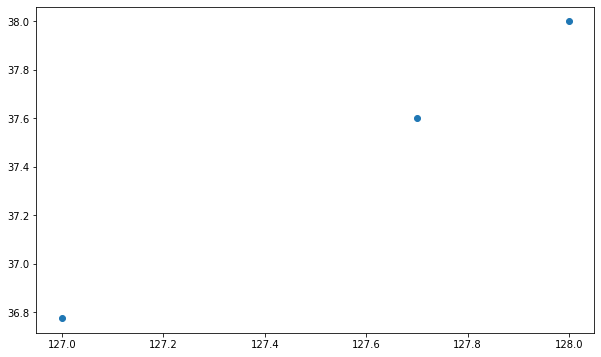

[0.24511949916419998, -0.026418792916221772]


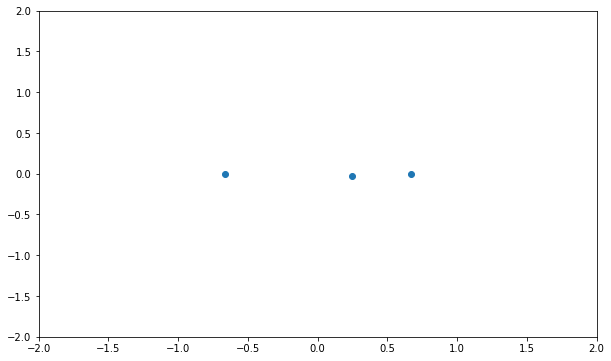

[ scalar, theta ] =  [0.24653908714371936, 6.175820518334271]
[ scalar, theta ] = [ 0.24653908714371936 , 1.965824726282501 pi ]


In [ ]:
from matplotlib import pyplot as plt

origin = [127, 36.7766]
destination = [128, 38]
coordinate_system = coordinate_rebuilding(origin, destination)  #출발지와 도착지를 넣어서 좌표계변환시스템 획득
waypoint = [127.7, 37.6]

x = np.array( [origin[0],destination[0] ,waypoint[0]])
y = np.array( [origin[1],destination[1] ,waypoint[1]])
plt.scatter(x, y)
plt.show()

#사용예시
transfered_waypoint = transfer_coordinate(waypoint, coordinate_system)

polar_coordinate_location = polar_coordinate(transfered_waypoint)
print(transfered_waypoint)
x = np.array([-0.6666666,0.6666666 ,transfered_waypoint[0]])
y = np.array([0,0 ,transfered_waypoint[1]])
plt.scatter(x, y)
plt.xlim([-2, 2]) 
plt.ylim([-2, 2])
plt.show()

rad = polar_coordinate_location[1] / math.pi
print("[ scalar, theta ] = ", polar_coordinate_location)
print("[ scalar, theta ] = [", polar_coordinate_location[0],",", rad, "pi ]")

#변환된 크기1의 극좌표를 vectorize하기

In [ ]:
import numpy as np
import math
def vectorize(X,count):#count는 정확도(노드 개수)
    '''
    x = 숫자 또는 numpy배열
    x는 1보다 작고 0보다 크다고 가정하자
    '''
    X[0,1] = X[0,1] / (math.pi*2) # theta값의 범위를 0~1로 조정

    arr = np.zeros(X.shape)
    for i in range(count):
        item = np.rint(X) # 1또는 0

        X = X - item /2
        X = X * 2
        arr = np.append(arr, item, axis = 0)
    arr = np.delete(arr,0,0)

    return arr

def de_vectorize(arr, count): #count는 정확도(노드 개수)
    X = np.zeros((1,arr.shape[1]))
    for i in range(count):
        item = arr[count-i-1]
        X = (X + item) / 2
    return X

In [ ]:
#사용예시
location = np.array(polar_coordinate_location)
#위에 극좌표계 변환 참조 ; 아무튼 크기1짜리 극좌표임

x = np.array([location])
count = 12 #count가 10이상은 되어야 정확도가 좋은듯, 10 이면 오차범위 0.3%, 12면 0.08%

x = vectorize(x,count)
print("벡터화 후 : <- 이녀석들이 Y가 됨. \n",x)

x = de_vectorize(x,count)
print("벡터화 풀기 :",x)

벡터화 후 : <- 이녀석들이 Y가 됨. 
 [[0. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [1. 0.]]
벡터화 풀기 : [[0.24633789 0.98291016]]


#데이터 input 전처리
-----------------------
 - origin, destination, 날짜를 넣으면 dataset으로 origin, destination, 해당요일 예상 유동인구, 국내 코로나 발생지를 신경망과 코로나회피점수계산을 위해 전처리를 함.

 - origin, destination은 극좌표 변환하면 무조건 (-0.666666,0), (0.6666666,0)이 되므로 좌표계변환 시스템을 구축하는 용도로 사용하고 버릴 수 있음.

 - 좌표계 변환시 크기조절 부분에서 x축방향으로 2/3만큼 더 수축되기 때문에 유동인구와 코로나발생지와의 거리측정시 x방향거리에 1.5를 곱해야 함.

 - 주변 코로나 발생지와 유동인구가 많은 지역과 origin - waypoint선분과 waypoint - destination선분의 거리를 전부 계산한 뒤 제곱후 역수를 취하고 적절히 더하여 (제곱하는 이유는 통계학적 원리, 거리가 너무 가까운 경우에는 고정값을 사용한다.) 코로나위험지수를 구하고 위험지수에 역수를 취해 회피점수를 얻는다.

In [ ]:
def get_corona_latlngs(ndarray):
  corona_latlng = np.zeros((1,2))
  for i in range (ndarray.shape[0]):
    latlng = get_latlng(ndarray[i],noise = False) #latlng 전처리 함수
    if latlng != "no_data":
      corona_latlng = np.append(corona_latlng, np.array([latlng]), axis = 0)
  corona_latlngs = np.delete(corona_latlng, 0,0)
  return corona_latlngs

In [ ]:
#가져온 코로나 발생지역을 출발지 목적지기반으로 극좌표로 변환하기
path = "Case.csv" #Case.csv
realPath = 'drive/My Drive/Dacon/PostCorona/[DS4C]코로나19확진자데이터/'+ path #컴퓨터가 content없는 Type
reader = pd.read_csv(realPath)

ndarray = reader.to_numpy()
gcl = get_corona_latlngs(ndarray)#코로나 맵 전처리시 선언 됨
def get_transfered_corona_locations(coordinate_sys,degree = 1.25):
  #극좌표변환전 좌표를 기록해야함. - 코로나회피점수계산을 위해서
  t_corona_locations = np.zeros((1,2))
  for i in range(gcl.shape[0]): #latlngs
    t_c_location = transfer_coordinate(gcl[i], coordinate_sys)
    p_c_location = polar_coordinate(t_c_location)# 스칼라값 구해서 영향력 체크
    if p_c_location[0] < degree: #영향력 있는 지역
      #print(t_c_location,"=>", p_c_location)
      t_corona_locations = np.append(t_corona_locations, np.array([t_c_location]), axis = 0)

  t_corona_locations = np.delete(t_corona_locations, 0, axis = 0)
  return t_corona_locations# 이 배열은 출발지와 목적지가 바뀌면 완전히 다른 값을 가짐

In [ ]:
#예시
origin = [37.38, 126.90]
destination = [37.46, 127.12]
coordinate_sys = coordinate_rebuilding(origin, destination)
t_corona_locations = get_transfered_corona_locations(coordinate_sys,1.25)
print(t_corona_locations)#영향력있는 좌표만 가져온다.

[[ 0.13803212 -1.00308248]
 [-0.46056253 -0.81557956]
 [-0.50077421 -1.07463139]
 [-0.50023893 -0.82793942]
 [-0.30741071 -0.72890584]
 [ 0.42910949 -1.01257664]
 [ 0.53746472 -0.32729197]
 [ 0.1400326  -1.21820949]
 [-0.22508905 -1.03955766]
 [ 0.45284282 -0.68327664]
 [ 0.26016788 -0.56971752]
 [-0.49530852 -0.87777737]
 [ 0.88109246  0.15616861]
 [ 0.53679805  0.58070803]
 [-0.46969051  0.09122336]
 [-0.23770268  1.07619854]
 [-0.32641509 -0.03006277]]


#waypoint와 t_corona_locations로 코로나 회피점수 구하기

In [ ]:
origin = [37.38, 126.90]
destination = [37.46, 127.12]
waypoint = [37.44, 127.01]

#사용예시
coordinate_sys = coordinate_rebuilding(origin, destination)# 좌표계변환시스템 획득
t_corona_locations = get_transfered_corona_locations(coordinate_sys)# 좌표계에 영향력있는 코로나발생지 가져오기

t_waypoint = transfer_coordinate(waypoint,coordinate_sys)

print(t_waypoint)

[0.038929440389286384, -0.1605839416058089]


In [ ]:
#간단히 변환된 좌표계의 경로와 코로나 점을 그려주는 함수
def draw_(t_waypoint, t_corona_locations):
  epsilon = 1e-16

  #plt.plot([origin[0],waypoint[0],destination[0]],[origin[1],waypoint[1],destination[1]])
  plt.plot([-0.66,t_waypoint[0],0.66],[0,t_waypoint[1],0], marker='o',color='black')
  plt.xlim([-2, 2]) 
  plt.ylim([-2, 2])

  for t_corona_location in t_corona_locations:
    plt.scatter(t_corona_location[0],t_corona_location[1],color='red') #코로나 지점
  plt.show()

def draw__(t_waypoint1,t_waypoint2, t_corona_locations):
  epsilon = 1e-16

  #plt.plot([origin[0],waypoint[0],destination[0]],[origin[1],waypoint[1],destination[1]])
  plt.plot([-0.66,t_waypoint1[0],t_waypoint2[0],0.66],[0,t_waypoint1[1],t_waypoint2[1],0], marker='o',color='black')
  plt.xlim([-2, 2]) 
  plt.ylim([-2, 2])

  for t_corona_location in t_corona_locations:
    plt.scatter(t_corona_location[0],t_corona_location[1],color='red') #코로나 지점
  plt.show()

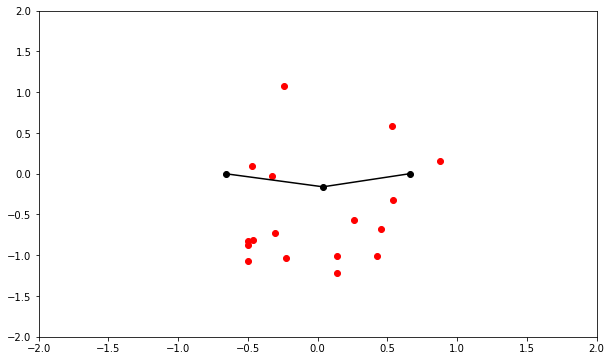

In [ ]:
draw_(t_waypoint, t_corona_locations) #그리기

In [ ]:
import math
def get_distance(a,b):
  '''
  점 a(x1,y2)과 b(x2,y2)의 거리구하는 함수
  '''
  dx = (b[0] - a[0]) * 1.5 #비율조절에 의해 축소된 x를 복구
  dy = b[1] - a[1]

  distance = (dx**2 + dy**2)**0.5

  return distance

def static(h,s1,s2):
  '''
  정적분하기
  '''
  epsilon = 1e-8
  if h < epsilon:
    h= epsilon
  if s2 < s1:
    s3 = s2
    s2 = s1
    s1 = s3
  t = math.atan(s2/h) /h - math.atan(s1/h) /h

  return t

def get_t_single_line(t_corona_location,t_origin,t_destination):
  '''
  직선경로 하나의 점수구하기
  '''
  a = get_distance(t_origin,t_destination) #origin과 destination의 거리 
  b = get_distance(t_corona_location,t_origin) #origin 과 코로나점의 거리
  c = get_distance(t_destination, t_corona_location) #destination과 코로나점의 거리

  cos_theta2 = (c**2 + a**2 -b**2) / (2*c*a) #코사인법칙으로 각 구하기
  sin_theta2 = (1 - cos_theta2**2)**0.5

  cos_theta1 = - (a**2+b**2-c**2) / (2*a*b)
  sin_theta1 = (1 - cos_theta1**2)**0.5

  h = c * sin_theta2 #높이
  s1 = c * cos_theta1 #적분 시작점
  s2 = c * cos_theta2 #적분 끝점

  return static(h,s1,s2) + 0.1/(b) + 0.1/(c)#정적분 + 점 거리기반 점수추가

def get_corona_avoid_point(t_corona_locations,t_waypoint):
  epsilon = 1e-8
  '''
  t_코로나 좌표들과 t_waypoint로 코로나 회피점수를 구한다.
  ''' 
  t_origin = [-2/3, 0 ]
  t_destination = [2/3, 0]
  T = 0
  
  for t_corona_location in t_corona_locations:
    tOrigin = get_t_single_line(t_corona_location, t_origin,t_waypoint) #먼저 출발지부터 waypoint까지의 위험점수 수집
    tDestination = get_t_single_line(t_corona_location, t_waypoint,t_destination) #waypoint부터 목적지까지의 위험점수를 수집
    d = get_distance(t_origin,t_waypoint)
    d+= get_distance(t_waypoint,t_destination)

    t = tOrigin + tDestination + d*0.5
    T += t # 전부 더한뒤 역수 취할 예정

  #T = t1 + t2 + t3 + ... 
  if T == 0:
    T = epsilon
  corona_avoid_point = 1/T

  return corona_avoid_point # 하나의 경로와 코로나 좌표들로 계산한 회피점수

def get_corona_avoid_point_two_of_waypoints(t_corona_locations,t_waypoint1,t_waypoint2):
  epsilon = 1e-8
  '''
  t_코로나 좌표들과 t_waypoint로 코로나 회피점수를 구한다.
  ''' 
  t_origin = [-2/3, 0 ]
  t_destination = [2/3, 0]
  T = 0
  
  for t_corona_location in t_corona_locations:
    tOrigin = get_t_single_line(t_corona_location, t_origin,t_waypoint1) #먼저 출발지부터 waypoint1까지의 위험점수 수집
    tWaypoint = get_t_single_line(t_corona_location, t_waypoint1,t_waypoint2) #waypoint에서 waypoint
    tDestination = get_t_single_line(t_corona_location, t_waypoint2,t_destination) #waypoint부터 목적지까지의 위험점수를 수집
    d = get_distance(t_origin,t_waypoint1)
    d += get_distance(t_waypoint1,t_waypoint2)
    d += get_distance(t_waypoint2,t_destination)

    t = tOrigin + tWaypoint + tDestination + d *0.5
    T += t # 전부 더한뒤 역수 취할 예정

  #T = t1 + t2 + t3 + ... 
  if T == 0:
    T = epsilon
  corona_avoid_point = 1/T

  return corona_avoid_point # 하나의 경로와 코로나 좌표들로 계산한 회피점수

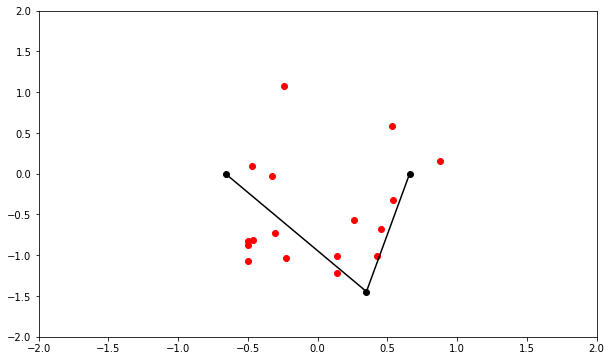

회피점수 : 0.2365125802569425


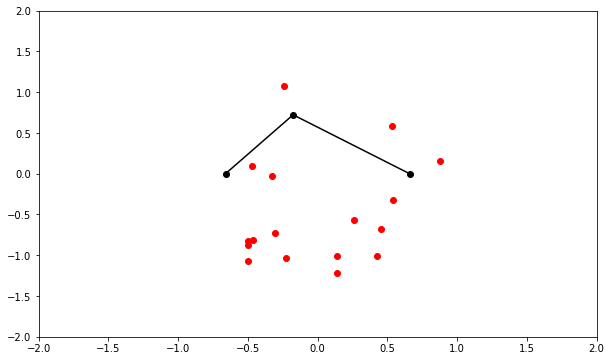

회피점수 : 1.3143854076724109


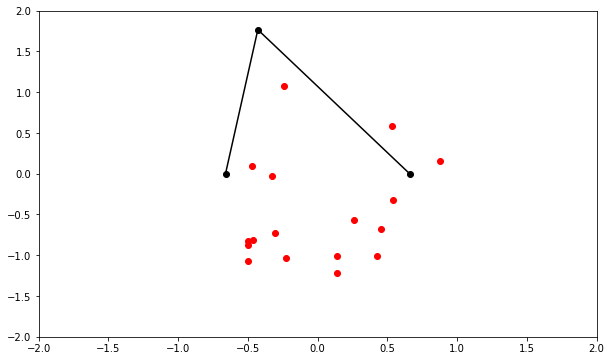

회피점수 : 1.0712103029685842


In [ ]:
origin = [37.38, 126.90]
destination = [37.46, 127.12]
waypoint = [37.60, 127.01]

coordinate_sys = coordinate_rebuilding(origin, destination)# 좌표계변환시스템 획득
t_corona_locations = get_transfered_corona_locations(coordinate_sys)# 좌표계에 영향력있는 코로나발생지 가져오기

t_waypoint = transfer_coordinate(waypoint,coordinate_sys)


draw_(t_waypoint, t_corona_locations) #시각화
#사용예시
# t_좌표계의 정보들을 미리 계산해두면 바로 사용할 수 있음
reward = 100 * get_corona_avoid_point(t_corona_locations, t_waypoint) 
print("회피점수 :",reward)

waypoint = [37.33, 127.01]
t_waypoint = transfer_coordinate(waypoint,coordinate_sys)
draw_(t_waypoint, t_corona_locations)
reward = 100 * get_corona_avoid_point(t_corona_locations, t_waypoint) 
print("회피점수 :",reward)

waypoint = [37.20, 127.01]
t_waypoint = transfer_coordinate(waypoint,coordinate_sys)
draw_(t_waypoint, t_corona_locations)
reward = 100 * get_corona_avoid_point(t_corona_locations, t_waypoint) 
print("회피점수 :",reward)

#X로 Y 만들기 

(X : 출발지, 목적지, 코로나발생 데이터 + etc)

(Y : 코로나 회피점수를 최대화 하는 t_waypoint의 벡터화된것)

----------------------------------------------------
생성된 Y로 지도학습을 진행하였으나 결과값이 만족스럽지 않아 Y생성알고리즘만을 사용하게 되었음.

In [ ]:
import random
def random_nodes(arr, count, random_ratio):
  r = int(random_ratio * count) #바꿔야하는 노드개수 = r

  for i in range(r):
    n = random.randint(0,count-1)
    m = random.randint(0,count-1)

    arr[n,0] = 1 - arr[n,0] # 1은 0으로 0은 1로
    arr[m,1] = 1 - arr[m,0]
  return arr


def create_Y(count,origin,destination,epoch=10000, all_random_cycle = 100, random_ratio = 0.1, degree = 1.25):
  '''
  count : 벡터화 정도; 이 값은 전체코드에서 동기화 되어야합니다.
  origin, destination : 출발지, 목적지의 절대좌표 ex) [37.60 , 127.04]
  epoch : 반복횟수
  all_random_cycle : all_random주기
  random_ratio : 고정에서 얼마나 random노드할 지 노드 100개에서 3개만 바꾸면 값은 0.03 -> 3개는 랜덤 선택함
  count * random_ratio 개의 노드가 랜덤으로 not된다.
  degree : 코로나 좌표 인식 범위

  하나의 X로 Y를 생성함.
  '''
  #t_좌표계시스템 제작
  coordinate_sys = coordinate_rebuilding(origin, destination)

  #t_좌표계산
  t_corona_locations = get_transfered_corona_locations(coordinate_sys,degree = degree)# 영향력있는 코로나좌표 가져오기

  Y = np.random.choice(2,(count,2)) #(세로, 가로) - 한번 올랜덤 돌린다.
  #처음 생성된 Y는 최대회피점수를 가지므로 회피점수도 계산해 준다.
 
  p_Y = de_vectorize(Y, count) #Y를 de-vectorize하여 극좌표계로 변환
  p_Y = np.array([p_Y[0][0], p_Y[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌

  #극좌표 p_Y를 t_Y로 바꾸면 waypoint를 얻을 수 있음.
  if t_corona_locations.shape[0] == 0:
    print("corona location is not exist\n set waypoint 0,0")
    t_waypoint = [0.0,0.0] #= 생성된 waypoint
  else:
    t_waypoint = [p_Y[0]*math.cos(p_Y[1]), p_Y[0]*math.sin(p_Y[1])] #= 생성된 waypoint
  t_Y = t_waypoint # 첫번째 생성된 waypoint는 무조건 최적의 waypoint임

  #t_waypoint로 코로나 회피점수를 계산할 수 있다.
  #draw_(t_waypoint, t_corona_locations) #시각화
  p_max = 100 * get_corona_avoid_point(t_corona_locations, t_waypoint) #첫번째 코로나 회피점수를 max에 저장

  for i in range(epoch):
    #랜덤 제작 하는 for문
    if (i+1) % all_random_cycle == 0 :
      #올랜덤 사이클에 의해 실행
      created_Y = np.random.choice(2,(count,2)) #(세로, 가로) - 한번 올랜덤 돌린다.
    
      p_Y = de_vectorize(Y, count) #Y를 de-vectorize하여 극좌표계로 변환
      p_Y = np.array([p_Y[0][0], p_Y[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌

      #극좌표 p_Y를 t_Y로 바꾸면 waypoint를 얻을 수 있음.
      t_waypoint = [p_Y[0]*math.cos(p_Y[1]), p_Y[0]*math.sin(p_Y[1])] #= 생성된 waypoint
      #t_waypoint로 코로나 회피점수를 계산할 수 있다.
      p = 100 * get_corona_avoid_point(t_corona_locations, t_waypoint) #t_waypoint로 p를 계산해봄.
      if p_max < p:
        #계산된 p가 기존 p_max보다 클 경우 Y는 대체됨.
        Y = created_Y #노드값 저장
        t_Y = t_waypoint #절대좌표값 저장
        p_max = p # 회피점수 갱신

    else:
      created_Y = random_nodes(Y, count, random_ratio) #최적의 Y에서 조금씩 변경해보기
    
      p_Y = de_vectorize(Y, count) #Y를 de-vectorize하여 극좌표계로 변환
      p_Y = np.array([p_Y[0][0], p_Y[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌

      #극좌표 p_Y를 t_Y로 바꾸면 waypoint를 얻을 수 있음.
      t_waypoint = [p_Y[0]*math.cos(p_Y[1]), p_Y[0]*math.sin(p_Y[1])] #= 생성된 waypoint

      #t_waypoint로 코로나 회피점수를 계산할 수 있다.
      p = 100 * get_corona_avoid_point(t_corona_locations, t_waypoint) #t_waypoint로 p를 계산해봄.
      if p_max < p:
        #계산된 p가 기존 p_max보다 클 경우 Y는 대체됨.
        Y = created_Y #노드값 저장
        t_Y = t_waypoint #좌표값 저장
        p_max = p # 회피점수 갱신

  draw_(t_Y, t_corona_locations) #시각화
  print("코로나 회피점수:",p_max)
  result = {}
  result["t_Y"] = t_Y
  result["coordinate_sys"] = coordinate_sys
  return result

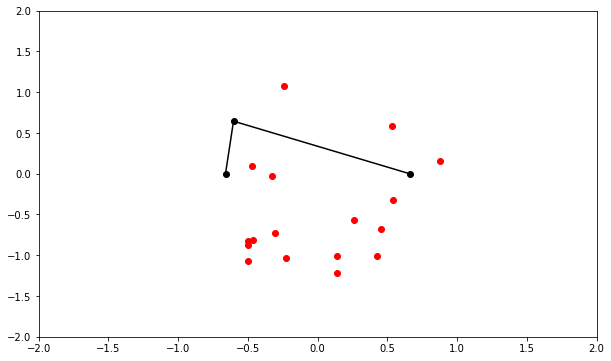

코로나 회피점수: 1.4258479715686547


In [ ]:
origin = [37.38, 126.90]
destination = [37.46, 127.12]
result = create_Y(20,origin,destination,epoch = 10000, all_random_cycle= 50, random_ratio = 0.2)

In [ ]:
#multi_waypoint -2개
def create_Y_waypoints(count,origin,destination,epoch=10000, all_random_cycle = 100, random_ratio = 0.1, degree = 1.25):
  '''
  count : 벡터화 정도; 이 값은 전체코드에서 동기화 되어야합니다.
  origin, destination : 출발지, 목적지의 절대좌표 ex) [37.60 , 127.04]
  epoch : 반복횟수
  all_random_cycle : all_random주기
  random_ratio : 고정에서 얼마나 random노드할 지 노드 100개에서 3개만 바꾸면 값은 0.03 -> 3개는 랜덤 선택함
  count * random_ratio 개의 노드가 랜덤으로 not된다.
  degree : 코로나 좌표 인식 범위

  하나의 X로 Y를 생성함.
  '''
  #t_좌표계시스템 제작
  coordinate_sys = coordinate_rebuilding(origin, destination)

  #t_좌표계산
  t_corona_locations = get_transfered_corona_locations(coordinate_sys,degree = degree)# 영향력있는 코로나좌표 가져오기

  Y1 = np.random.choice(2,(count,2)) #(세로, 가로) - 한번 올랜덤 돌린다.
  Y2 = np.random.choice(2,(count,2))
  #처음 생성된 Y는 최대회피점수를 가지므로 회피점수도 계산해 준다.

  p_Y1 = de_vectorize(Y1, count) #Y를 de-vectorize하여 극좌표계로 변환
  p_Y1 = np.array([p_Y1[0][0], p_Y1[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌
  p_Y2 = de_vectorize(Y2, count) #Y를 de-vectorize하여 극좌표계로 변환
  p_Y2 = np.array([p_Y2[0][0], p_Y2[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌

  #극좌표 p_Y를 t_Y로 바꾸면 waypoint를 얻을 수 있음.
  if t_corona_locations.shape[0] == 0:
    print("corona location is not exist\n set waypoint 0,0")
    t_waypoint1 = [-0.1,0.0] #= 생성된 waypoint
    t_waypoint2 = [0.1,0.0]
  else:
    t_waypoint1 = [-0.1,0.0] #= 생성된 waypoint
    t_waypoint2 = [0.1,0.0]
    #t_waypoint1 = [p_Y1[0]*math.cos(p_Y1[1]), p_Y1[0]*math.sin(p_Y1[1])] #= 생성된 waypoint
    #t_waypoint2 = [p_Y2[0]*math.cos(p_Y2[1]), p_Y2[0]*math.sin(p_Y2[1])] #= 생성된 waypoint
  t_Y1 = t_waypoint1 # 첫번째 생성된 waypoint는 무조건 최적의 waypoint임
  t_Y2 = t_waypoint2 # 첫번째 생성된 waypoint는 무조건 최적의 waypoint임

  #t_waypoint로 코로나 회피점수를 계산할 수 있다.
  #draw__(t_waypoint1,t_waypoint2, t_corona_locations) #시각화
  p_max = 100 * get_corona_avoid_point_two_of_waypoints(t_corona_locations, t_waypoint1,t_waypoint2) #첫번째 코로나 회피점수를 max에 저장
  for i in range(epoch):
    #랜덤 제작 하는 for문
    if (i+1) % all_random_cycle == 0 :
      #올랜덤 사이클에 의해 실행
      created_Y1 = np.random.choice(2,(count,2)) #(세로, 가로) - 한번 올랜덤 돌린다.
      created_Y2 = np.random.choice(2,(count,2))
    
      p_Y1 = de_vectorize(created_Y1, count) #Y를 de-vectorize하여 극좌표계로 변환
      p_Y1 = np.array([p_Y1[0][0], p_Y1[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌
      p_Y2 = de_vectorize(created_Y2, count) #Y를 de-vectorize하여 극좌표계로 변환
      p_Y2 = np.array([p_Y2[0][0], p_Y2[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌

      #극좌표 p_Y를 t_Y로 바꾸면 waypoint를 얻을 수 있음.
      t_waypoint1 = [p_Y1[0]*math.cos(p_Y1[1]), p_Y1[0]*math.sin(p_Y1[1])] #= 생성된 waypoint
      t_waypoint2 = [p_Y2[0]*math.cos(p_Y2[1]), p_Y2[0]*math.sin(p_Y2[1])] #= 생성된 waypoint
      #t_waypoint로 코로나 회피점수를 계산할 수 있다.
      p = 100 * get_corona_avoid_point_two_of_waypoints(t_corona_locations, t_waypoint1, t_waypoint2) #t_waypoint로 p를 계산해봄.
      if p_max < p:
        #계산된 p가 기존 p_max보다 클 경우 Y는 대체됨.
        Y1 = created_Y1 #노드값 저장
        Y2 = created_Y2 #노드값 저장
        t_Y1 = t_waypoint1 #절대좌표값 저장
        t_Y2 = t_waypoint2 #절대좌표값 저장
        p_max = p # 회피점수 갱신

    else:
      created_Y1 = random_nodes(Y1, count, random_ratio) #최적의 Y에서 조금씩 변경해보기
      created_Y2 = random_nodes(Y2, count, random_ratio) #최적의 Y에서 조금씩 변경해보기
    
      p_Y1 = de_vectorize(Y1, count) #Y를 de-vectorize하여 극좌표계로 변환
      p_Y1 = np.array([p_Y1[0][0], p_Y1[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌
      p_Y2 = de_vectorize(Y2, count) #Y를 de-vectorize하여 극좌표계로 변환
      p_Y2 = np.array([p_Y2[0][0], p_Y2[0][1]*2*math.pi]) # 1번 세로줄은 범위가 2pi까지이므로 비율을 곱해줌

      #극좌표 p_Y를 t_Y로 바꾸면 waypoint를 얻을 수 있음.
      t_waypoint1 = [p_Y1[0]*math.cos(p_Y1[1]), p_Y1[0]*math.sin(p_Y1[1])] #= 생성된 waypoint
      t_waypoint2 = [p_Y2[0]*math.cos(p_Y2[1]), p_Y2[0]*math.sin(p_Y2[1])] #= 생성된 waypoint

      #t_waypoint로 코로나 회피점수를 계산할 수 있다.
      p = 100 * get_corona_avoid_point_two_of_waypoints(t_corona_locations, t_waypoint1, t_waypoint2) #t_waypoint로 p를 계산해봄.
      if p_max < p:
        #계산된 p가 기존 p_max보다 클 경우 Y는 대체됨.
        Y1 = created_Y1 #노드값 저장
        Y2 = created_Y2 #노드값 저장
        t_Y1 = t_waypoint1 #좌표값 저장
        t_Y2 = t_waypoint2 #좌표값 저장
        p_max = p # 회피점수 갱신
  draw__(t_Y1,t_Y2, t_corona_locations) #시각화
  print("p_max",p_max)

  result = {}
  result["t_Y1"] = t_Y1
  result["t_Y2"] = t_Y2
  result["coordinate_sys"] = coordinate_sys
  return result

아래는 Y생성알고리즘으로 waypoint를 한개, 두개 버전으로 나누어 생성.

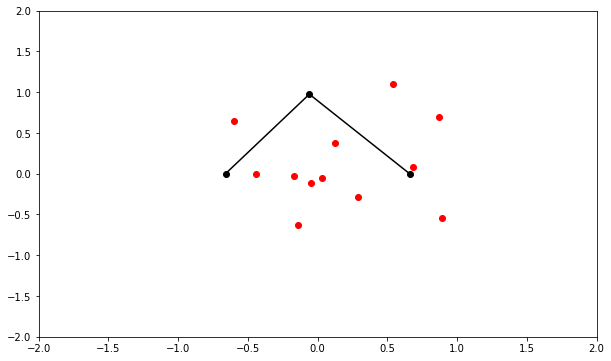

코로나 회피점수: 1.1135746184067907


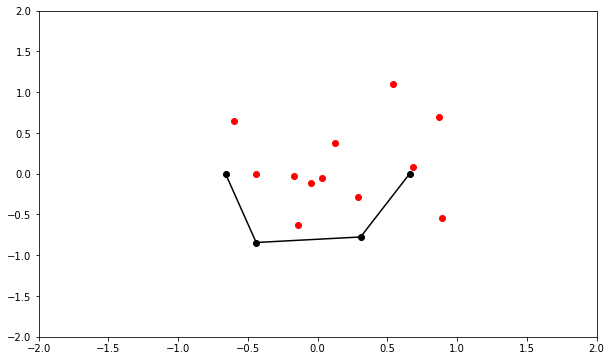

p_max 1.2849387616393904


In [ ]:
origin = "홍대입구역"
destination = "왕십리역"

origin = address_to_location_list(origin)
destination = address_to_location_list(destination)
result = create_Y(20,origin,destination,epoch = 10000, all_random_cycle= 50, random_ratio = 0.2)
result2 = create_Y_waypoints(20,origin,destination,epoch = 10000, all_random_cycle= 50, random_ratio = 0.2)

single_t_Y = result["t_Y"]

t_Y1 = result2["t_Y1"]
t_Y2 = result2["t_Y2"]
cord = result2["coordinate_sys"]

single_waypoint = inverse_transfer_coordinate(single_t_Y,cord)
waypoint1 = inverse_transfer_coordinate(t_Y1,cord)
waypoint2 = inverse_transfer_coordinate(t_Y2,cord)

origin = location_to_string(origin)
destination = location_to_string(destination)
single_waypoint = location_to_string(single_waypoint)
waypoint1 = location_to_string(waypoint1)
waypoint2 = location_to_string(waypoint2)


지도에 표시해보았습니다.

In [ ]:
map1 = request_direction(origin, destination)
map2 = request_direction(origin, destination, waypoint1, waypoint2)
map3 = request_direction(origin, destination, single_waypoint)

display(map1)
display(map2)
display(map3)

순서대로
no waypoint
two waypoints
single waypoint

In [ ]:
display(map1)

In [ ]:
display(map2)

In [ ]:
display(map3)

직접 지도에서 경로탐색을 해보니 몇개의 문제점이 발견 되었습니다.

- waypoint의 생성위치가 부적절한 경우 : waypoint가 대중교통을 이용하기 부적절한 위치거나 강또는 바다 위에 생성 되면 경로가 생성되지 않음.

- waypoint를 가기위해 경로가 많이 길어지는 경우 : 오히려 코로나 발생지를 많이 거치됨.

-> waypoint의 위치를 가까운 지하철또는 버스정류장의 위치로 변경해야 함.

외부데이터 및 api 출처
------------------------
------------------------
구글 맵 api를 이용하여 geocoding과 Directions을 활용했습니다.

https://cloud.google.com/maps-platform?hl=ko

공공데이터 포털의 한국교통공단의 버스정류소 및 노선정보를 사용했습니다.

https://www.data.go.kr/dataset/15034305/fileData.do

Github에서 geoJson을 clone하여 Json파일을 서울특별시부분만 따로 사용했습니다.

https://github.com/vuski/admdongkor

------------------------
구글맵 경로의 points를 해석하는 코드를 github에서 받아 사용했습니다.

https://github.com/geodav-tech/decode-google-maps-polyline 

------------------------
**'본 저작물의 저작권은 Apache License v2.0을 따릅니다'**
-------------------------------------------------------------